In [ ]:
#-----------------------------------------------------------------------------------------------------------
#     CÁLCULO DA PRECIPITAÇÃO ACUMULADA PARA O MÊS DE FEVERIERO
#          COMPARADA COM CADA RODADA DO MODELO EC-SAZONAL
#-----------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

import sys

sys.path.insert(1, '/mnt/c/scripts/tools/')

from bigquery_bucket_tools import *
from plot_tools import *
from tools import *


import time as t
from datetime import datetime, timedelta, date 
from dateutil.relativedelta import *
from netCDF4 import Dataset   
import glob
import requests 
import pandas as pd
import xarray as xr
import requests 
import functools
import operator
import wget
import os
import gc
import numpy as np
import pygrib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller



import geopandas as gpd
import shapely
import shapefile
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy, cartopy.crs as ccrs   
import geopandas as gpd
import regionmask
from shapely.geometry import Point, Polygon

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import scipy.ndimage as ndimage
from PIL import Image
from scipy.ndimage import gaussian_filter
import scipy.ndimage

from google.cloud import storage, bigquery

In [ ]:
SECO = pd.read_csv('/mnt/c/scripts/Disp_carga_e_temp/arquivos/SECO_detrend.csv')

S = pd.read_csv('/mnt/c/scripts/Disp_carga_e_temp/arquivos/S_detrend.csv')
NE = pd.read_csv('/mnt/c/scripts/Disp_carga_e_temp/arquivos/NE_detrend.csv')
N = pd.read_csv('/mnt/c/scripts/Disp_carga_e_temp/arquivos/N_detrend.csv')
# SECO

In [ ]:
files=[SECO,S,NE,N]

Cálculo da Regrssão no dado sem tendência 
-------------------------------------------

mean_temperature
-----------------------

In [49]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)          
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)
        min = np.min(Y_pred_quad)
        # print('Y_pred_quad min:',min)
        

        frame['Y_pred_quad'] = Y_pred_quad #curva 


        


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)
        
        # print('Y_pred_cub min:',min)


        frame['Y_pred_cub'] = Y_pred_cub #curva 
        
        
        # # max_y = np.min(Y_pred_cub)
        # # loc = np.where(Y_pred_cub == max_y)
        #         # print('Ponto max:', max )
        # # print('Ponto  x:', loc )
        # # print('\n')
       
       
        # ymax = Y_pred_cub[np.argmax(y)]
        # xmax = y.max()
        # print('Ponto max:', ymax )
        # print('Ponto  x:', xmax )
        # # print('\n')





        df_fim = pd.concat([df_fim, frame], axis=0)

Ponto max: [34950.10610149]
Ponto  x: 46127.91872531444
Ponto max: [10414.26390971]
Ponto  x: 16487.02197573065
Ponto max: [8553.38710208]
Ponto  x: 12634.67847121132
Ponto max: [4261.80026254]
Ponto  x: 6931.27265328347


In [51]:
# df_fim

# df_fim.P3.describe()

In [11]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')

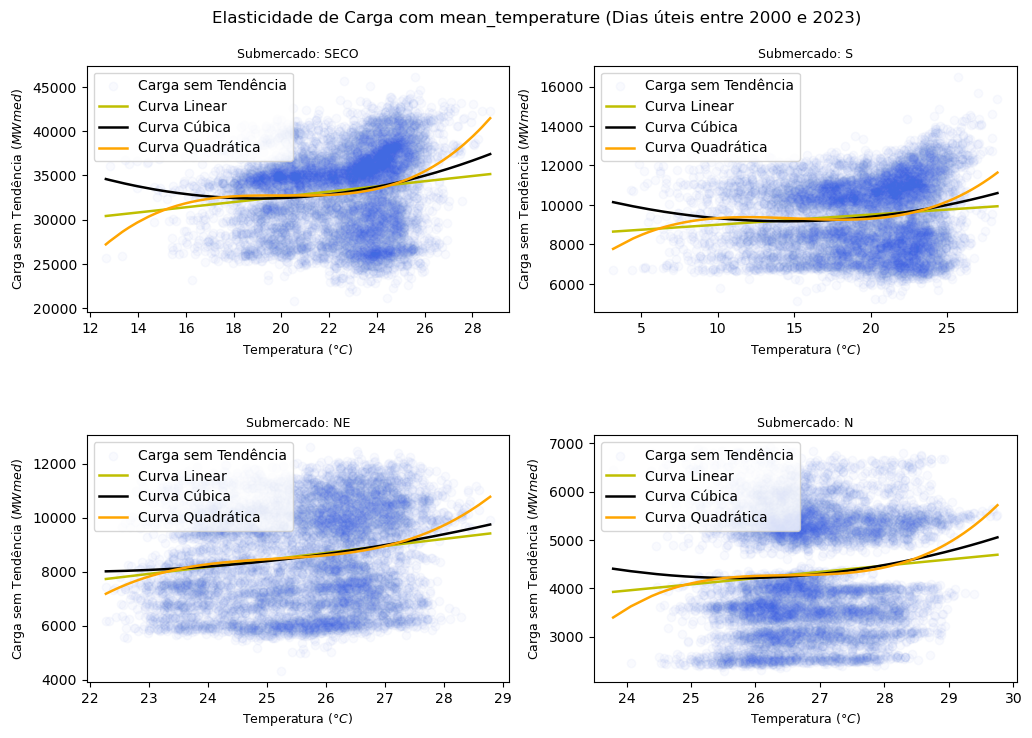

In [53]:

lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com mean_temperature (Dias úteis entre 2000 e 2023)", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        # pylab.plot(x0,rsinc(x0),'bd',xmin0,rsinc(xmin0),'bo')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear','Curva Cúbica','Curva Quadrática'])
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('mean_temperature.png',dpi=150)



In [26]:
SECO.Y_pred_cub.min()

26318.663149089014

mean_temperature_pop
--------------------------

In [44]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature_pop").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)     #     
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)

        frame['Y_pred_quad'] = Y_pred_quad #curva 


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)

        frame['Y_pred_cub'] = Y_pred_cub #curva 



        df_fim = pd.concat([df_fim, frame], axis=0)

In [45]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')





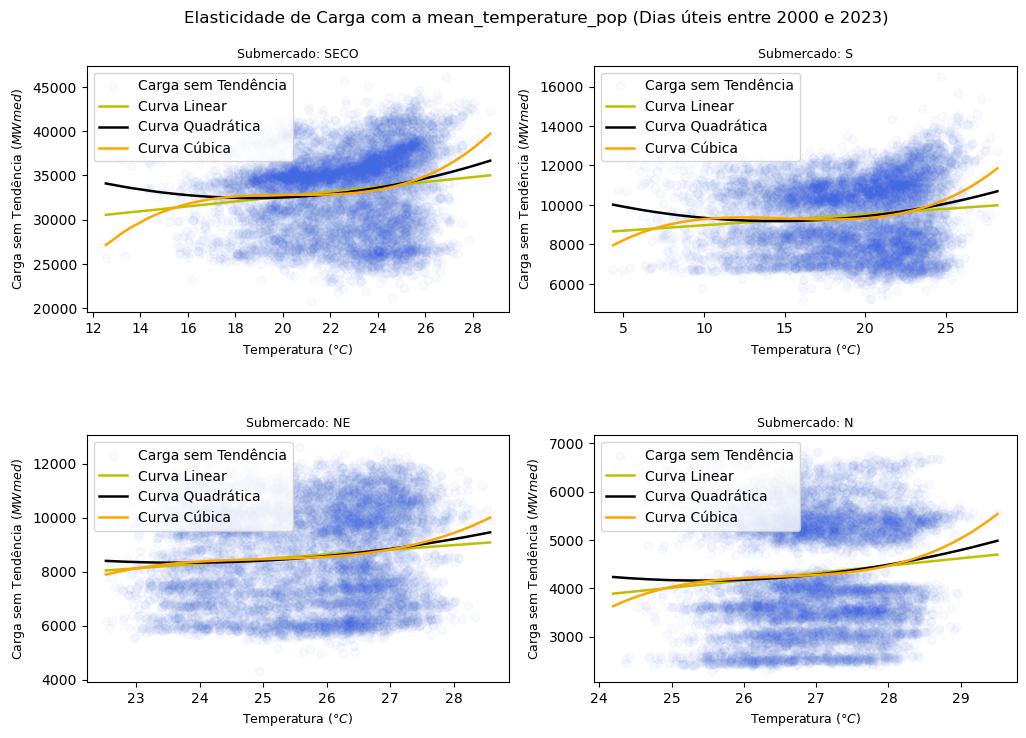

In [47]:

lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com a mean_temperature_pop (Dias úteis entre 2000 e 2023)", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature_pop,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear','Curva Quadrática','Curva Cúbica'],loc='upper left')
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('mean_temperature_pop.png',dpi=150)



mean_temperature_ons
-----------------------

In [32]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature_ons").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)     #     
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)

        frame['Y_pred_quad'] = Y_pred_quad #curva 


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)

        frame['Y_pred_cub'] = Y_pred_cub #curva 



        df_fim = pd.concat([df_fim, frame], axis=0)

In [33]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')

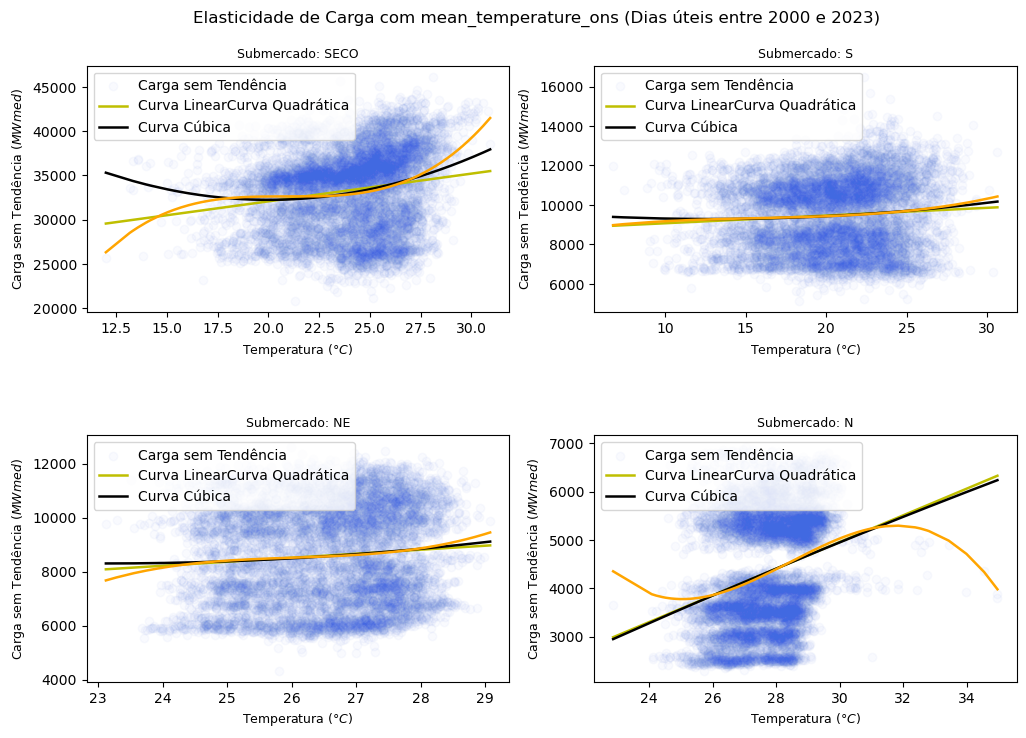

In [36]:

lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com mean_temperature_ons (Dias úteis entre 2000 e 2023)", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature_ons,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear''Curva Quadrática','Curva Cúbica'],loc='upper left')
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('mean_temperature_ons.png')

